In [73]:
# Import Neccesary Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [2]:
train_path = r"C:\Users\ibrom\Downloads\dataset\dataset\MADAR-Corpus-26-train.tsv"
dev_path = r"C:\Users\ibrom\Downloads\dataset\dataset\MADAR-Corpus-26-dev.tsv"
train_data = pd.read_csv(train_path, sep = '\t')
dev_data = pd.read_csv(dev_path, sep = '\t')

train_data.head()

,هناك ، أمام بيانات السائح تماما .,MSA
0,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,MSA
1,استمر في السير في هذا الطريق حتى تجد صيدلية .,MSA
2,كم تكلفة الإفطار ؟,MSA
3,كيف أستطيع مساعدتك ؟,MSA
4,اتجه يسارا عند الناصية الثالثة .,MSA


In [3]:
train_data.tail()

,هناك ، أمام بيانات السائح تماما .,MSA
41594,هل في مكتبه قريبه من هنايا ؟,TRI
41595,اني بنخش مدرسه صيفه في جامعة هاواي .,TRI
41596,من وين خاطمين حني توا ؟,TRI
41597,زوز كبار و عيل تلاته سنين .,TRI
41598,في حمام في المحطة .,TRI


In [4]:
#Let's do a random sampling of the data
train_data.sample(6)

,هناك ، أمام بيانات السائح تماما .,MSA
37506,أنا مقفل . يمكنك فتح بابي ، من فضلك .,MUS
21928,باخذ هذي الوجبة الثابتة .,RIY
24856,حاضر الخمسة غدوة ؟,SFX
22311,اذا وجدت أي شيء ، لو سمحت كلمني .,RIY
33471,واش عندك علامة الاستلام ديالك ؟,FES
34257,هل هناك طبيب الفندق أو واحد في الاتصال ؟,KHA


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41599 entries, 0 to 41598
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   هناك ، أمام بيانات السائح تماما .  41599 non-null  object
 1   MSA                                41599 non-null  object
dtypes: object(2)
memory usage: 650.1+ KB


In [6]:
#Checking if the data contains missing values
train_data.isnull().sum()

هناك ، أمام بيانات السائح تماما .    0
MSA                                  0
dtype: int64

In [7]:
#Checking the total number of word contained in the data
print(train_data['هناك ، أمام بيانات السائح تماما .'].apply(lambda x: len(x.split(' '))).sum())

294737


In [8]:
#Checking the Arabic dialects contained in the label
print(train_data['MSA'].unique())

['MSA' 'BEI' 'CAI' 'DOH' 'RAB' 'TUN' 'ALX' 'ALG' 'AMM' 'ASW' 'DAM' 'JED'
 'JER' 'RIY' 'SAN' 'SFX' 'ALE' 'BAG' 'BAS' 'BEN' 'FES' 'KHA' 'MOS' 'MUS'
 'SAL' 'TRI']


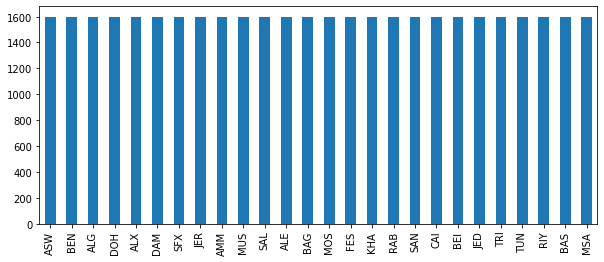

In [9]:
#Checking how balanced the data is
plt.figure(figsize=(10,4))
train_data['MSA'].value_counts().plot(kind = 'bar')

We have a very balanced dataset

In [81]:
'''
The first step is to subject the data to preprocessing.
This involves removing both arabic and english punctuation
Normalizing different letter variants with one common letter
'''
# first we define a list of arabic and english punctiations that we want to get rid of in our text

punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
stop_words = stopwords.words()

arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def preprocess(text):
    
    '''
    text is an arabic string input
    
    the preprocessed text is returned
    '''
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    #remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

train_data["هناك ، أمام بيانات السائح تماما ."] = train_data["هناك ، أمام بيانات السائح تماما ."].apply(preprocess)
#Let's have a look at our preprocessed data
train_data.head(3)

,هناك ، أمام بيانات السائح تماما .,MSA
0,اسمع بهذا العنوان قبل بالقرب,MSA
1,استمر السير الطريق حتي تجد صيدليه,MSA
2,تكلفه الافطار,MSA


In [11]:
#total Number of words after preprocessing
#Checking the total number of word contained in the data
print(train_data['هناك ، أمام بيانات السائح تماما .'].apply(lambda x: len(x.split(' '))).sum())

253014


In [12]:
#splitting the feature and the label in order to make transformations

X = train_data['هناك ، أمام بيانات السائح تماما .']
y = train_data['MSA']

#transform the feature into bag our words

#create the transform
vectorizer = CountVectorizer()
#tokenize and build vocabulary
vectorizer.fit(X)
print(vectorizer.get_feature_names()[:200])
vector = vectorizer.transform(X)

['iso', 'اءتمان', 'اءتماني', 'اءتمانيتان', 'اءتمانيتين', 'اءتمانيه', 'اءجر', 'اا', 'ااا', 'ااااه', 'اااه', 'ااجر', 'ااجرعربيه', 'ااجل', 'ااحسها', 'ااذا', 'اار', 'اارب', 'ااستماره', 'ااكد', 'االبيت', 'االتزم', 'االتهاب', 'االلي', 'االمفروض', 'اامن', 'اانت', 'اانسه', 'ااني', 'ااه', 'ااهاا', 'ااوي', 'اايس', 'اب', 'ابءا', 'ابا', 'اباب', 'اباك', 'اباكيت', 'ابالك', 'اباها', 'اباهم', 'اباوع', 'اباي', 'ابباي', 'اببي', 'ابتاعين', 'ابتداء', 'ابتداءا', 'ابتدينا', 'ابتع', 'ابثه', 'ابحث', 'ابد', 'ابدا', 'ابدل', 'ابدلالقطار', 'ابدي', 'ابديتموه', 'ابرد', 'ابرك', 'ابرم', 'ابريق', 'ابريل', 'ابسر', 'ابسرت', 'ابسرتها', 'ابسرك', 'ابسره', 'ابسرها', 'ابشع', 'ابص', 'ابصر', 'ابصلك', 'ابطء', 'ابطا', 'ابعت', 'ابعتا', 'ابعتلك', 'ابعتلي', 'ابعته', 'ابعتها', 'ابعتو', 'ابعث', 'ابعثلي', 'ابعثها', 'ابعثو', 'ابعثوا', 'ابعد', 'ابعه', 'ابغا', 'ابغاان', 'ابغاك', 'ابغد', 'ابغي', 'ابغيت', 'ابغيك', 'ابق', 'ابقا', 'ابقشيش', 'ابقه', 'ابقوا', 'ابقي', 'ابل', 'ابلغ', 'ابلغه', 'ابله', 'ابناءهم', 'ابنتك', 'ابني', 'ابو', 'ابواب', '

In [82]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [83]:
#We need to transform our text into bag of words in order to be able to work with it

#first instantiate the tranformer, we use TfidfVectorizer in this case
tfidf_vectorizer = TfidfVectorizer()
#tokenize and build vocab
tfidf_vectorizer.fit(X_train)
#summarize
#print(tfidf_vectorizer.vocabulary_)
print(tfidf_vectorizer.idf_)
# encode document
X_train_tfidf = tfidf_vectorizer.transform(X_train)
print(vector.shape)

[10.58603332  8.02108396 10.58603332 ...  9.89288614 10.58603332
 10.58603332]
(41599, 24623)


In [15]:
'''
Here we try different Algorithm to know the best one to work with
An empty list is first defined and models are appended to it
Cross validation is then instantiated in order to evaluate how different algorithm performed

'''
def ModelSelection():
    
    models = []
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 55)))
    models.append(('NB', MultinomialNB()))
    models.append(('LR', LogisticRegression(max_iter=2050)))
    models.append(('SDG', SGDClassifier()))
    #models.append(('SVM', SVC(kernel = 'rbf', random_state = 0)))

    results = []
    names = []
    #evaluating the algorithm
    for name, model in models:
      kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
      cv_results = cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
      results.append(cv_results)
      names.append(name)
      print(f"{name}: {cv_results.mean()} ({cv_results.std()})")
    
ModelSelection()

KNN: 0.3905350961302524 (0.0059860000742484225)
NB: 0.4268343763330451 (0.004915576827697167)
LR: 0.43658758366333084 (0.0071808221927937566)
SDG: 0.4312306531496673 (0.004892347473355644)


In [19]:
plt.boxplot(results, labels=names)
plt.show()

NameError: name 'results' is not defined

In [84]:
NMB = Pipeline([('vect', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
NMB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [85]:
pred = NMB.predict(X_test)
print(accuracy_score(y_test, pred))

0.41394230769230766


In [36]:
NMB = MultinomialNB(alpha=1)
NMB.fit( X_train_tfidf, y_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
pred = NMB.predict(X_test_tfidf)
print(accuracy_score(y_test, pred))

0.437099358974359


In [47]:
LR = LogisticRegression(max_iter=250)
LR.fit( X_train_tfidf, y_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
pred = LR.predict(X_test_tfidf)

0.4440705128205128
              precision    recall  f1-score   support

         ALE       0.41      0.47      0.44       468
         ALG       0.67      0.68      0.68       476
         ALX       0.30      0.27      0.28       486
         AMM       0.30      0.29      0.30       457
         ASW       0.34      0.44      0.38       475
         BAG       0.51      0.45      0.48       519
         BAS       0.44      0.42      0.43       494
         BEI       0.45      0.50      0.47       481
         BEN       0.47      0.50      0.48       470
         CAI       0.26      0.21      0.23       466
         DAM       0.34      0.30      0.32       483
         DOH       0.41      0.41      0.41       491
         FES       0.59      0.51      0.54       465
         JED       0.36      0.45      0.40       447
         JER       0.39      0.31      0.35       493
         KHA       0.46      0.54      0.49       470
         MOS       0.67      0.60      0.63       496
        

In [48]:
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

0.4440705128205128
              precision    recall  f1-score   support

         ALE       0.41      0.47      0.44       468
         ALG       0.67      0.68      0.68       476
         ALX       0.30      0.27      0.28       486
         AMM       0.30      0.29      0.30       457
         ASW       0.34      0.44      0.38       475
         BAG       0.51      0.45      0.48       519
         BAS       0.44      0.42      0.43       494
         BEI       0.45      0.50      0.47       481
         BEN       0.47      0.50      0.48       470
         CAI       0.26      0.21      0.23       466
         DAM       0.34      0.30      0.32       483
         DOH       0.41      0.41      0.41       491
         FES       0.59      0.51      0.54       465
         JED       0.36      0.45      0.40       447
         JER       0.39      0.31      0.35       493
         KHA       0.46      0.54      0.49       470
         MOS       0.67      0.60      0.63       496
        

In [42]:
def Predict(text):
    translator = str.maketrans('', '', punctuations)  # remove puntctuations
    text = text.translate(translator)
    #normalizing
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    #tranform into vectors
    
    text = tfidf_vectorizer.transform([text])
    #make predictions
    prediction = LR.predict(text)
    
    return prediction
    

In [43]:
Predict('أدي الأجرة عمنشستر ؟')

array(['BEI'], dtype=object)

In [57]:
dev_data[415:425]

,بالمناسبة ، اسمي هيروش إيجيما .,MSA
415,ده غالي ، مش كده ؟,CAI
416,ممكن تخلي عندك شنطتي لحد الساعة تلاته ؟,CAI
417,ممكن احجز اجر - عربية هنا ؟,CAI
418,انت نسيت مشروباتنا ؟,CAI
419,عندنا بيرة ، ويسكي ، براندي . جين . فودكا . و ...,CAI
420,بكام الاجرة لمانشستر ؟,CAI
421,ادي الرقم .,CAI
422,أحتمال . لكن لازم نوزن كل حاجة لوحدها .,CAI
423,الاتوبيس ده رايح فندق هيلتون ؟,CAI
424,ممكن أعزمك عالعشاء في وقت ما ؟,CAI


In [58]:
sample = dev_data['بالمناسبة ، اسمي هيروش إيجيما .'][415:425]
print(sample)

415                                   ده غالي ، مش كده ؟
416              ممكن تخلي عندك شنطتي لحد الساعة تلاته ؟
417                          ممكن احجز اجر - عربية هنا ؟
418                                 انت نسيت مشروباتنا ؟
419    عندنا بيرة ، ويسكي ، براندي . جين . فودكا . و ...
420                               بكام الاجرة لمانشستر ؟
421                                          ادي الرقم .
422              أحتمال . لكن لازم نوزن كل حاجة لوحدها .
423                       الاتوبيس ده رايح فندق هيلتون ؟
424                       ممكن أعزمك عالعشاء في وقت ما ؟
Name: بالمناسبة ، اسمي هيروش إيجيما ., dtype: object


In [59]:
pred = [Predict(text) for text in sample]
pred

[array(['ALX'], dtype=object),
 array(['CAI'], dtype=object),
 array(['CAI'], dtype=object),
 array(['ASW'], dtype=object),
 array(['BEI'], dtype=object),
 array(['ALX'], dtype=object),
 array(['BEI'], dtype=object),
 array(['TRI'], dtype=object),
 array(['CAI'], dtype=object),
 array(['KHA'], dtype=object)]